# **Detection of Covid Positive Cases using Image Processing**

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 98% 765M/778M [00:07<00:00, 153MB/s]
100% 778M/778M [00:07<00:00, 113MB/s]


In [ ]:
! unzip covid19-radiography-database.zip

# Loading Required Libraries

In [7]:
# Data Reading
import os
from PIL import Image

# Data Processing
import numpy as np
import pandas as pd
import cv2


# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt


# Data Modeling & Model Evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Reading The Data

In [8]:
levels = ['Normal', 'COVID']
path = "./COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level+"/images")):
        data.append(['{}/{}'.format(level+"/images", file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-25.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...
1,Normal/images/Normal-2488.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...
2,Normal/images/Normal-5082.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...
3,Normal/images/Normal-2643.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...
4,Normal/images/Normal-7290.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...


In [9]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


# Exploratory Data Analysis

### 1. Count Plot

In [10]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count',
             color = "corona_result", text_auto='', width = 600,
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Image Samples

In [11]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-25.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...,"[[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Normal/images/Normal-2488.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,Normal/images/Normal-5082.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...,"[[206, 138, 34, 7, 14, 18, 18, 18, 18, 18, 17,..."
3,Normal/images/Normal-2643.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...,"[[13, 11, 12, 11, 11, 10, 11, 10, 9, 9, 9, 9, ..."
4,Normal/images/Normal-7290.png,Negative,./COVID-19_Radiography_Dataset/Normal/images/N...,"[[5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."


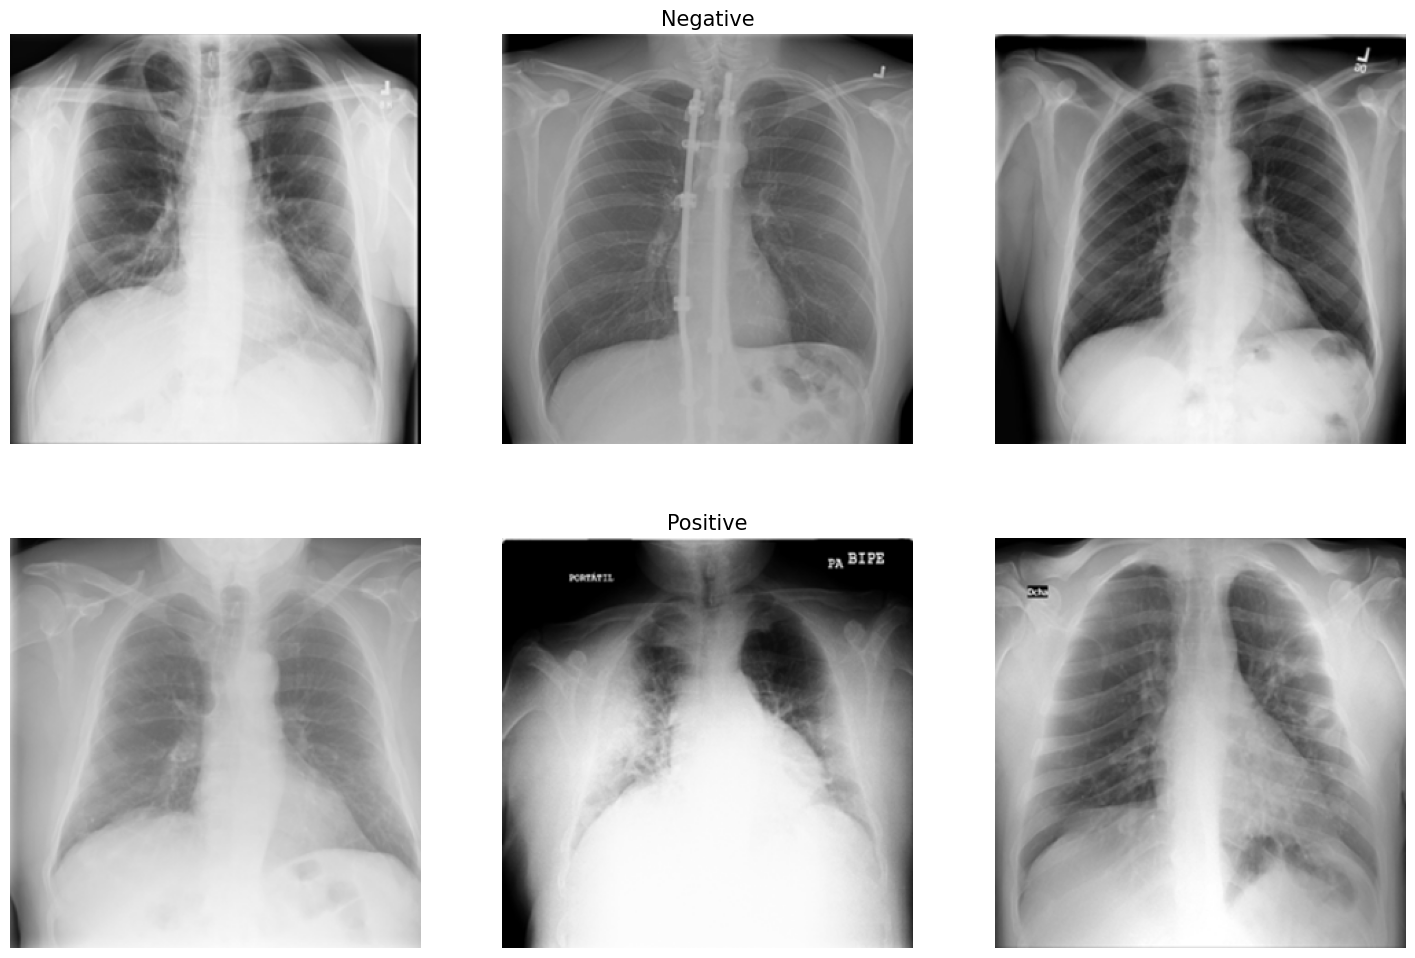

In [12]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

# Data Modeling

### Train Test Split

In [13]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [14]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


### CNN Model

In [15]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam',
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 34, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

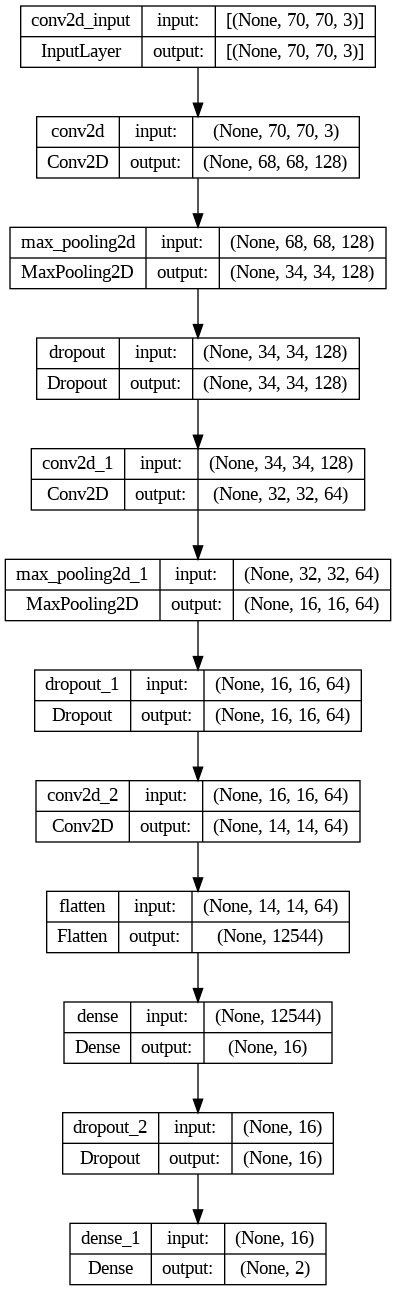

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model = cnn_model, show_shapes=True)

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train,
                        epochs = 50, batch_size = 256,
                        validation_data = (x_val, y_val),
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 16s 178ms/step - loss: 0.6181 - accuracy: 0.7319 - val_loss: 0.5501 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 4s 103ms/step - loss: 0.5130 - accuracy: 0.7330 - val_loss: 0.4485 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 4s 103ms/step - loss: 0.4783 - accuracy: 0.7330 - val_loss: 0.4302 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 4s 105ms/step - loss: 0.4373 - accuracy: 0.7788 - val_loss: 0.3687 - val_accuracy: 0.8443
Epoch 5/50
39/39 [==============================] - 4s 107ms/step - loss: 0.3829 - accuracy: 0.8261 - val_loss: 0.3226 - val_accuracy: 0.8434
Epoch 6/50
39/39 [==============================] - 4s 105ms/step - loss: 0.3485 - accuracy: 0.8608 - val_loss: 0.2974 - val_accuracy: 0.8706
Epoch 7/50
39/39 [==============================] - 4s 104ms/step - loss: 0.3361 - accuracy: 0.8698 - val_loss: 0.2789 - val_accuracy: 0.8896
Epoch

In [18]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

87/87 [==============================] - 0s 5ms/step


### Model Evaluation

In [19]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):

    print("\n-----------------------------{}-----------------------------\n".format(name))

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)

    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")

    t3.plot()


-----------------------------Convolution Neural Network-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2061
           1       0.92      0.92      0.92       701

    accuracy                           0.96      2762
   macro avg       0.95      0.95      0.95      2762
weighted avg       0.96      0.96      0.96      2762

--------------------------------------------------------------------------
Recall on Test Data:  0.9244
Specificity on Test Data:  0.9728
Accuracy on Test Data:  0.9605
Precision on Test Data:  0.9205
F1 Score Test Data:  0.9224
--------------------------------------------------------------------------


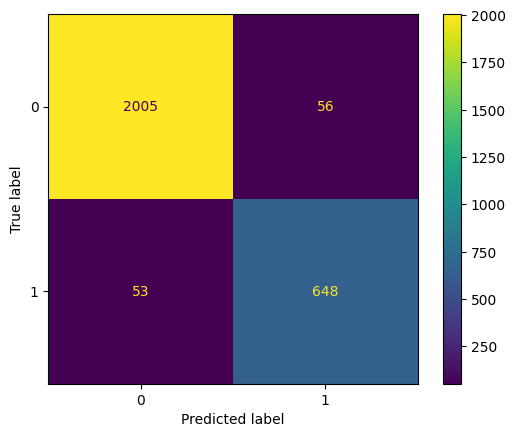

In [20]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

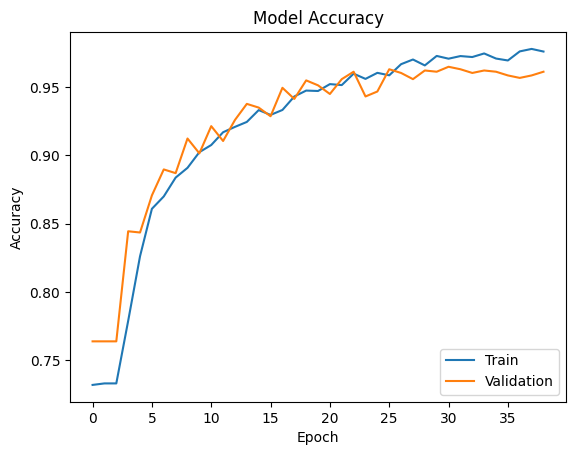

In [21]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

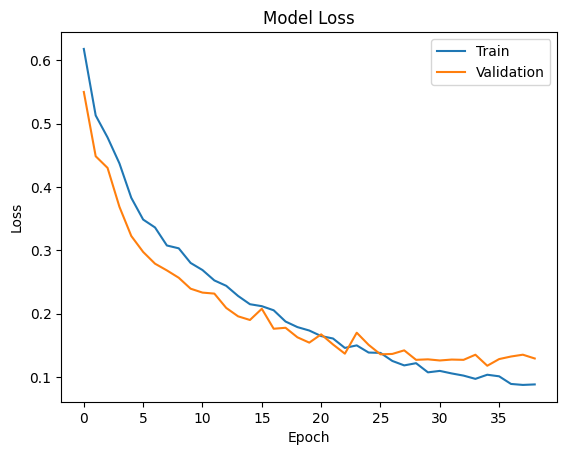

In [22]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

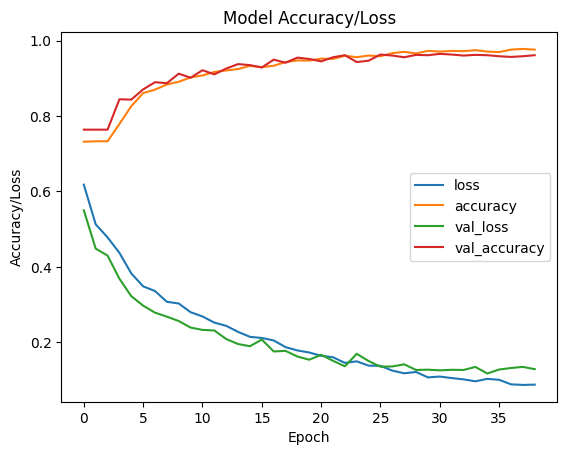

In [23]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

> We observe that Train & Validation Accuracy's Curve slightly overlap and same with Loss Curve.

> Hence, Overfitting is avoided, this is possible because of Dropout Regularization & Early Stopping Metrics.

### Checking with Model

In [24]:
# Checking predictions for the above sample images
img_path = ["./COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png",
            "./COVID-19_Radiography_Dataset/COVID/images/COVID-101.png",
            "./COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png",
           "./COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png"]

for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (70, 70)) / 255.0
    # print(z_img)
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    # print(z_img)
    z = cnn_model.predict(z_img)
    print(z)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)

1/1 [==============================] - 0s 221ms/step
[[-0.3109123   0.23856944]]
Image 1 : [1]
1/1 [==============================] - 0s 26ms/step
[[-0.4889928   0.40895742]]
Image 2 : [1]
1/1 [==============================] - 0s 24ms/step
[[14.405199 -6.551993]]
Image 3 : [0]
1/1 [==============================] - 0s 24ms/step
[[14.770229  -4.8760724]]
Image 4 : [0]


# Saving Model

In [25]:
cnn_model.save('cnn_model.keras')